# Temp Analysis Luki

In [341]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [342]:
sns.set_theme()

In [343]:
TEMP_PROCESSED_FOLDER = 'data/processed/temperature/'
TEMP_GLOBAL_FILE = 'temp-land-ocean-global.csv'
TEMP_REGION_FILE = 'temp-land-region.csv'
TEMP_COUNTRY_FILE = 'temp-land-country.csv'

In [344]:
temp_global = pd.read_csv(TEMP_PROCESSED_FOLDER+TEMP_GLOBAL_FILE)
temp_region = pd.read_csv(TEMP_PROCESSED_FOLDER+TEMP_REGION_FILE)
temp_country = pd.read_csv(TEMP_PROCESSED_FOLDER+TEMP_COUNTRY_FILE)

Group yearly

In [345]:
temp_global_yearly = temp_global.groupby(["year"])["temperature_anomaly"].mean()
temp_global_yearly = temp_global_yearly.reset_index()
temp_country_yearly = temp_country.groupby(["year","country_code"]).agg({"temperature_anomaly":"mean","country_name":"first"})
temp_country_yearly.reset_index(inplace=True)
temp_region_yearly = temp_region.groupby(["year","region_code"]).agg({"temperature_anomaly":"mean","region_name":"first"})
temp_region_yearly.reset_index(inplace=True)

Add smoothing

In [346]:
# applies lowess smoothing to each group
# if no group is supplied lowess will be applied to the whole dataset
def lowess_grouped(data: pd.DataFrame, x_name: str, y_name: str, group_name, frac: float):
    df = data.copy()
    y_name_smoothed = y_name + "_smooth"
    if group_name is not None:
        groups = df[group_name].unique().tolist()
        smoothed_dfs = []
        for group in groups:
            df_by_select_group = df[df[group_name] == group]
            smoothed_df = sm.nonparametric.lowess(df_by_select_group[y_name],df_by_select_group[x_name],frac=frac)
            smoothed_df = pd.DataFrame(smoothed_df)
            smoothed_df.columns = [x_name, y_name_smoothed]
            smoothed_df[x_name] = smoothed_df[x_name].astype(int)
            smoothed_df[group_name] = group
            smoothed_dfs.append(smoothed_df)
        return pd.merge(df,pd.concat(smoothed_dfs), how="left", on=[x_name,group_name])
    else:
        smoothed_df = sm.nonparametric.lowess(df[y_name], df[x_name], frac=frac)
        smoothed_df = pd.DataFrame(smoothed_df)
        smoothed_df.columns = [x_name, y_name_smoothed]
        return pd.merge(df,smoothed_df, how="left", on=x_name)

In [347]:
temp_global_yearly = lowess_grouped(temp_global_yearly, "year", "temperature_anomaly", None, frac=0.05)
temp_region_yearly = lowess_grouped(temp_region_yearly, "year", "temperature_anomaly", "region_name", frac=0.05)
temp_country_yearly = lowess_grouped(temp_country_yearly, "year", "temperature_anomaly", "country_name", frac=0.05)

## Global

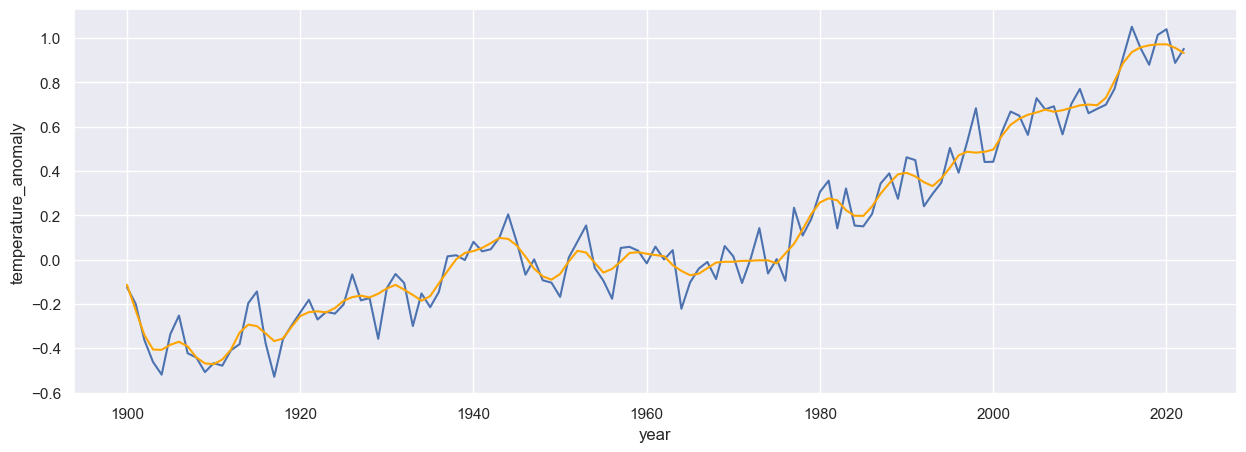

In [348]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="year", y="temperature_anomaly", data=temp_global_yearly)
sns.lineplot(x="year", y="temperature_anomaly_smooth", data=temp_global_yearly, color="orange");

## Regions

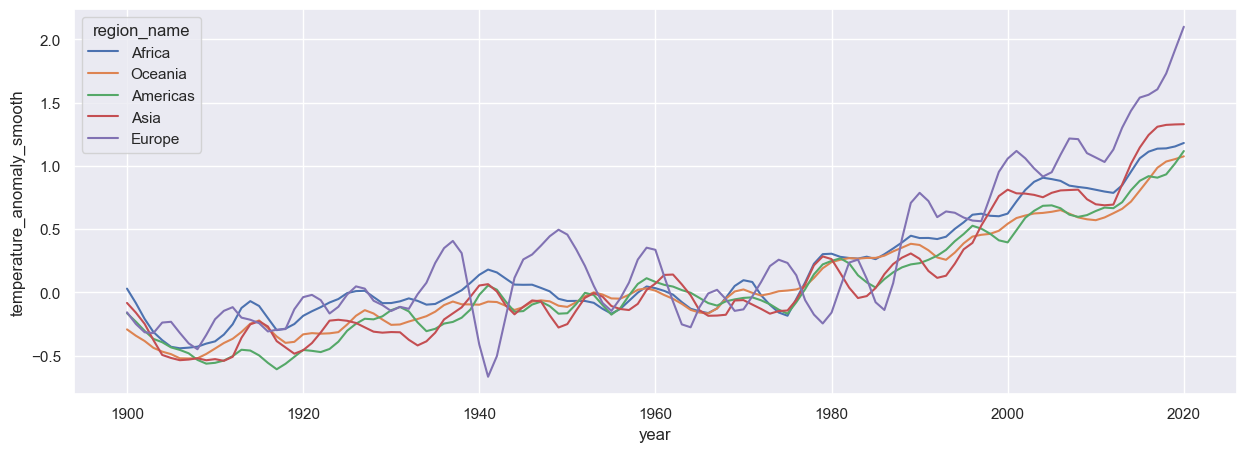

In [349]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="year",y="temperature_anomaly_smooth",hue="region_name",data=temp_region_yearly, ax=ax);

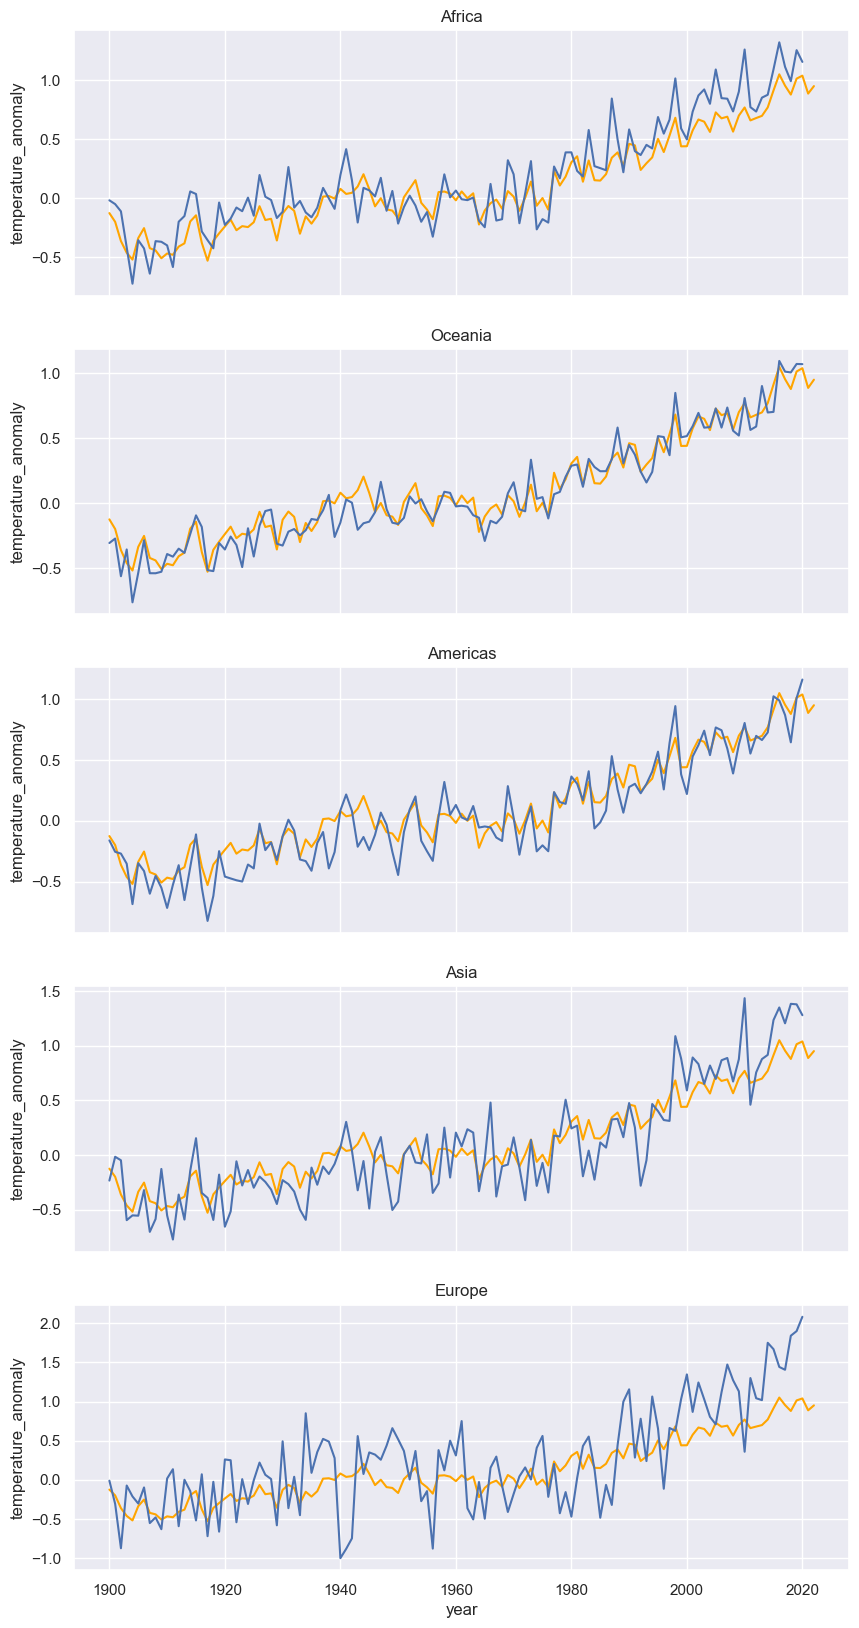

In [350]:
temp_regions = temp_region_yearly["region_name"].unique().tolist()
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(10, 20))
for i, region in enumerate(temp_regions):
    sns.lineplot(x="year",y="temperature_anomaly",data=temp_global_yearly, ax=axes[i], color='orange')
    sns.lineplot(x="year",y="temperature_anomaly",data=temp_region_yearly[temp_region_yearly["region_name"]==region], ax=axes[i])
    axes[i].set_title(region)

## Countries

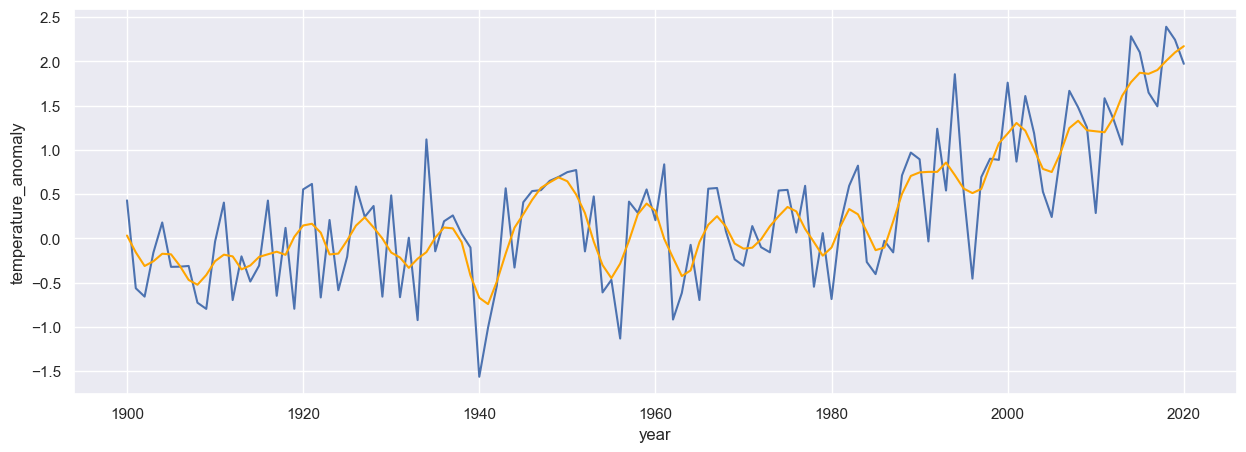

In [354]:
temp_aut = temp_country_yearly[temp_country_yearly["country_code"]=="AUT"]
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="year",y="temperature_anomaly",data=temp_aut, ax=ax)
sns.lineplot(x="year",y="temperature_anomaly_smooth",data=temp_aut, ax=ax, color="orange");